In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import glob
from sklearn.utils import shuffle as shf
import seaborn as sns
import random
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import load_model

from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm


np.random.seed(2023)
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import skimage
from skimage.transform import resize
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf
from keras.utils import img_to_array, img_to_array, load_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , MaxPool2D, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,roc_auc_score, roc_curve,confusion_matrix,accuracy_score,auc
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle as shf

from sklearn.metrics import confusion_matrix
import seaborn as sns

import optparse
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path  = '/content/drive/MyDrive/Brain_Tumor_MRI_Dataset'
train = path + '/train/'
test  = path + '/test/'
val = path+'/val/'
path,train,test,val

('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset',
 '/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/train/',
 '/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/test/',
 '/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/val/')

Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(zoom_range = 0.3,
                                   horizontal_flip = True
                                   )
test_datagen = ImageDataGenerator()

In [ ]:
train_gen = train_datagen.flow_from_directory(
                            directory = train,
                            target_size = (160, 160),
                            batch_size = 16,
                            class_mode = 'categorical',
                            shuffle=True)

test_gen = train_datagen.flow_from_directory(
                            directory = test,
                            target_size = (160, 160),
                            batch_size = 16,
                            class_mode = 'categorical',
                            shuffle=True)

Found 1359 images belonging to 3 classes.
Found 512 images belonging to 3 classes.


In [ ]:
train_gen.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2}

Learning Rate and Model Checkpoint

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max')
cp = ModelCheckpoint(filepath='eff_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

MODEL: EfficientNetB5

In [ ]:
from keras.applications.efficientnet import EfficientNetB5

from keras import layers
from keras.models import Sequential

model_EffNetB5_1101 = Sequential()
model_EffNetB5_1101.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(160,160,3)))
model_EffNetB5_1101.add(layers.GlobalAveragePooling2D())
model_EffNetB5_1101.add(layers.Dropout(0.5))
model_EffNetB5_1101.add(layers.Dense(3,activation = 'softmax'))

model_EffNetB5_1101.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history_eff = model_EffNetB5_1101.fit(
           train_gen, steps_per_epoch=train_gen.samples/32,
           epochs=4,
           validation_data=test_gen,
           validation_steps=test_gen.samples // 32,
           callbacks=[lr, cp],
           verbose=1)
model_EffNetB5_1101.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelEffNetB5.h5")
readyModelEff=load_model('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelEffNetB5.h5')

Epoch 1/4
42/42 [==============================] - 658s 14s/step - loss: 0.5647 - accuracy: 0.7715 - val_loss: 0.9870 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/4
42/42 [==============================] - 497s 12s/step - loss: 0.3170 - accuracy: 0.8952 - val_loss: 2.3100 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 3/4
42/42 [==============================] - 454s 11s/step - loss: 0.2280 - accuracy: 0.9215 - val_loss: 1.0092 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/4
42/42 [==============================] - 495s 12s/step - loss: 0.2796 - accuracy: 0.8981 - val_loss: 0.3293 - val_accuracy: 0.8945 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



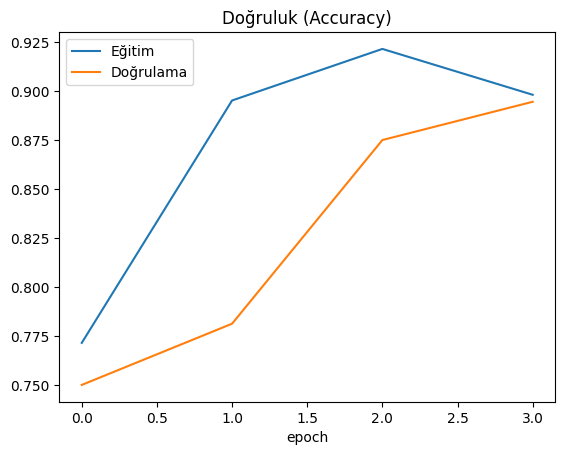

In [ ]:
plt.figure()
plt.plot(history_eff.history['accuracy'])
plt.plot(history_eff.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

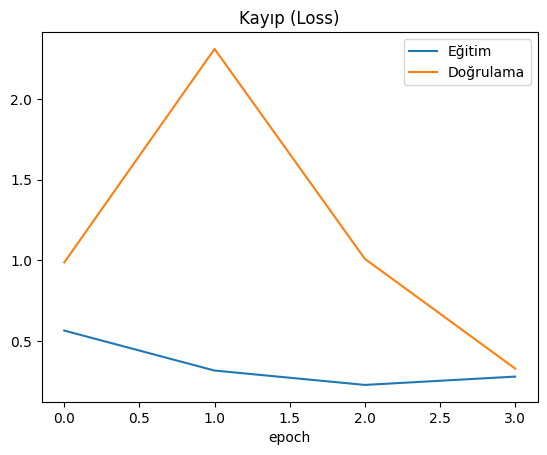

In [ ]:
plt.figure()
plt.plot(history_eff.history['loss'])
plt.plot(history_eff.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')



```
# This is formatted as code
```

MODEL:RESNET4

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

model_2 = Sequential([

Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
MaxPool2D((2, 2)),

Conv2D(32, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

Conv2D(256, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

Flatten(),
Dense(units=1024, activation='relu'),
Dropout(rate=0.3),

Dense(units=3, activation='softmax') ])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)
history_cnn = model_2.fit(
           train_gen,
           steps_per_epoch=train_gen.samples/24,
           epochs=10,
           validation_data=test_gen,
           validation_steps=test_gen.samples // 24,
           callbacks = [cp])
model_2.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/resnet4_13.h5")
readyModel=load_model("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/resnet4_13.h5")

Epoch 1/10
56/56 [==============================] - 49s 853ms/step - loss: 0.8211 - accuracy: 0.7409 - val_loss: 0.6721 - val_accuracy: 0.6815
Epoch 2/10
56/56 [==============================] - 52s 918ms/step - loss: 0.5786 - accuracy: 0.7980 - val_loss: 1.3570 - val_accuracy: 0.6071
Epoch 3/10
56/56 [==============================] - 43s 758ms/step - loss: 0.5111 - accuracy: 0.7719 - val_loss: 0.6287 - val_accuracy: 0.7173
Epoch 4/10
56/56 [==============================] - 47s 834ms/step - loss: 0.4910 - accuracy: 0.8244 - val_loss: 1.6807 - val_accuracy: 0.5714
Epoch 5/10
56/56 [==============================] - 43s 745ms/step - loss: 0.4742 - accuracy: 0.8377 - val_loss: 0.5075 - val_accuracy: 0.7887
Epoch 6/10
56/56 [==============================] - 50s 880ms/step - loss: 0.3978 - accuracy: 0.8607 - val_loss: 1.6401 - val_accuracy: 0.5982
Epoch 7/10
56/56 [==============================] - 47s 831ms/step - loss: 0.3636 - accuracy: 0.8640 - val_loss: 0.6508 - val_accuracy: 0.7619

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



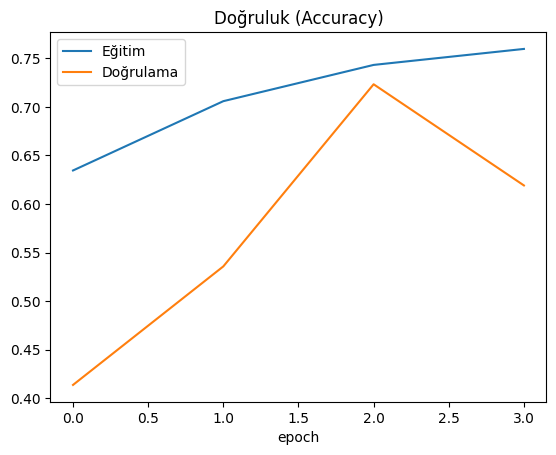

In [ ]:
plt.figure()
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

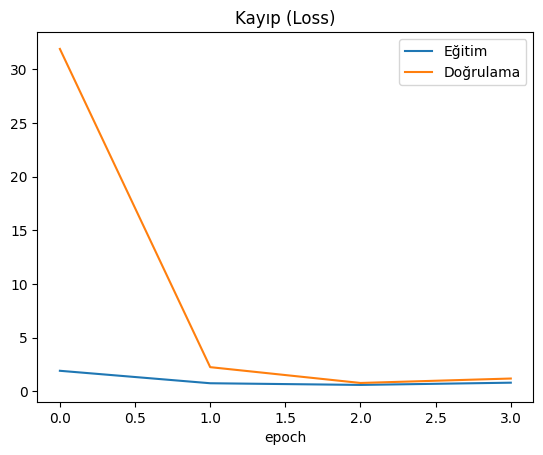

In [ ]:
plt.figure()
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')

MODEL: VGG16

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16 = VGG16(include_top= False, input_shape= (160, 160, 3), weights= 'imagenet')
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                              

In [ ]:
from keras.layers import Flatten,Dropout,Dense
from IPython.display import SVG
from tensorflow import keras
from keras.utils import model_to_dot, plot_model

model_3 = Sequential()

for layer in vgg16.layers:
    model_3.add(layer)

for layer in model_3.layers:
    layer.trainable= False

model_3.add(Flatten(input_shape= (4, 4, 512)))
model_3.add(Dropout(0.2))
model_3.add(Dense(3,activation='softmax'))

model_3.summary()

SVG(model_to_dot(model_3).create(prog='dot', format='svg'))
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

model_3.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 40, 40, 256)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
history_3 = model_3.fit(
    train_gen,
    epochs = 3,
    steps_per_epoch=train_gen.samples/32,
    validation_data = test_gen,
    validation_steps=test_gen.samples // 32,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True
)

model_3.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelVGG16.h5")
readyModelVGG=("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelVGG16.h5")

Epoch 1/3
43/42 [==============================] - ETA: -1s - loss: 3.5540 - accuracy: 0.7307
Epoch 1: val_loss improved from inf to 3.36347, saving model to baseline_model.h5
42/42 [==============================] - 220s 5s/step - loss: 3.5540 - accuracy: 0.7307 - val_loss: 3.3635 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 2/3
43/42 [==============================] - ETA: -1s - loss: 1.6702 - accuracy: 0.8777
Epoch 2: val_loss did not improve from 3.36347
42/42 [==============================] - 216s 5s/step - loss: 1.6702 - accuracy: 0.8777 - val_loss: 6.0778 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 3/3
43/42 [==============================] - ETA: -1s - loss: 1.5056 - accuracy: 0.8952
Epoch 3: val_loss did not improve from 3.36347
42/42 [==============================] - 217s 5s/step - loss: 1.5056 - accuracy: 0.8952 - val_loss: 4.0923 - val_accuracy: 0.8320 - lr: 0.0010


Text(0.5, 0, 'epoch')

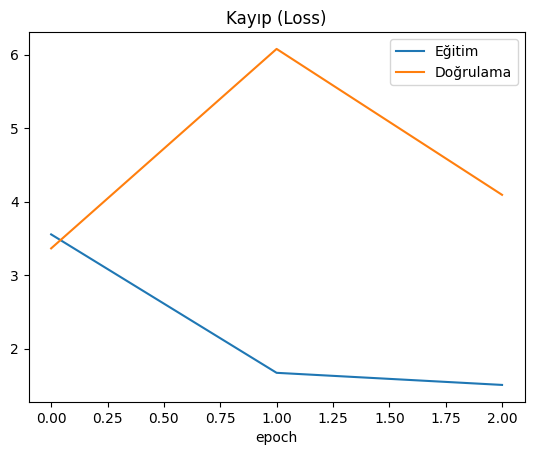

In [ ]:
plt.figure()
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')

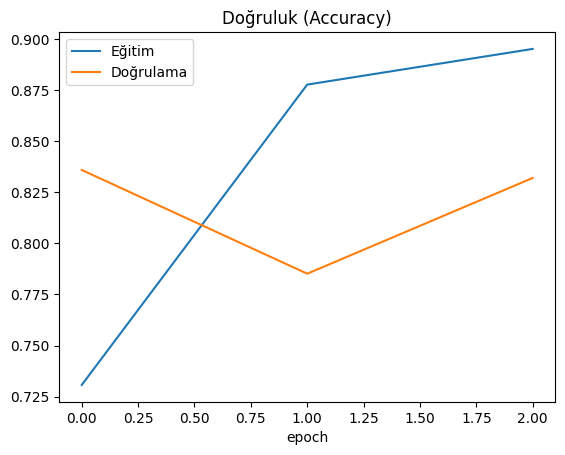

In [ ]:
plt.figure()
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

MODEL: ourModel

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

ourModel = Sequential([

Conv2D(16, (2, 2), activation='relu', input_shape=(160, 160, 3)),
MaxPool2D((2, 2)),

Conv2D(32, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(128, (2, 2), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(3, 3)),
Dropout(rate=0.4),

Flatten(),
Dense(units=1024, activation='relu'),
Dropout(rate=0.3),

Dense(units=3, activation='softmax') ])

ourModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)
history_ourModel = ourModel.fit(
           train_gen,
           steps_per_epoch=train_gen.samples/24,
           epochs=15,
           validation_data=test_gen,
           validation_steps=test_gen.samples // 24,
           callbacks = [cp])
ourModel.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/ourModel.h5")
readyOurModel=load_model("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/ourModel.h5")

Epoch 1/15
56/56 [==============================] - 43s 754ms/step - loss: 0.4570 - accuracy: 0.8112 - val_loss: 0.6426 - val_accuracy: 0.7143
Epoch 2/15
56/56 [==============================] - 38s 673ms/step - loss: 0.4527 - accuracy: 0.8035 - val_loss: 0.5072 - val_accuracy: 0.7917
Epoch 3/15
56/56 [==============================] - 39s 682ms/step - loss: 0.4808 - accuracy: 0.7958 - val_loss: 0.5708 - val_accuracy: 0.7321
Epoch 4/15
56/56 [==============================] - 43s 754ms/step - loss: 0.4561 - accuracy: 0.7925 - val_loss: 0.4619 - val_accuracy: 0.7946
Epoch 5/15
56/56 [==============================] - 44s 762ms/step - loss: 0.4446 - accuracy: 0.8112 - val_loss: 0.4335 - val_accuracy: 0.8214
Epoch 6/15
56/56 [==============================] - 43s 758ms/step - loss: 0.4169 - accuracy: 0.8191 - val_loss: 0.6975 - val_accuracy: 0.7440
Epoch 7/15
56/56 [==============================] - 38s 667ms/step - loss: 0.3831 - accuracy: 0.8299 - val_loss: 0.5249 - val_accuracy: 0.7917

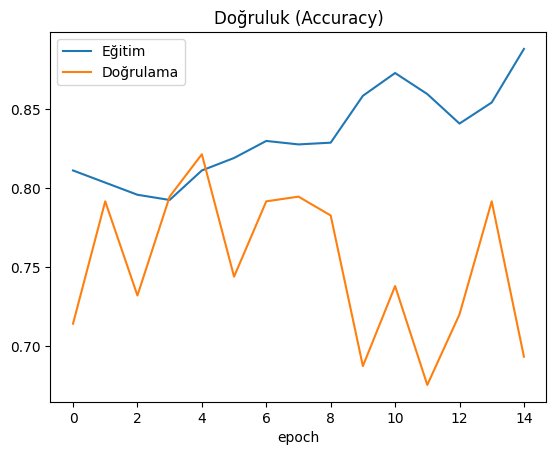

In [ ]:
plt.figure()
plt.plot(history_ourModel.history['accuracy'])
plt.plot(history_ourModel.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

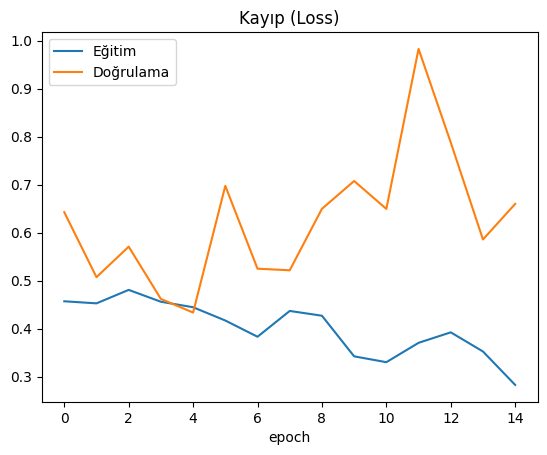

In [ ]:
plt.figure()
plt.plot(history_ourModel.history['loss'])
plt.plot(history_ourModel.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')

Confusion Matrix

In [ ]:
imageSize=160
train_dir = "/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/train/"
test_dir =  "/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/test/"

X = []
y = []
for folderName in os.listdir(test_dir):
    if not folderName.startswith('.'):
        if folderName in ['glioma']:
            label = 0
        elif folderName in ['meningioma']:
            label = 1
        elif folderName in ['notumor']:
            label = 2

        else:
            label = 3
        for image_filename in tqdm(os.listdir(test_dir + folderName)):
            img_file = cv2.imread(test_dir + folderName + '/' + image_filename)
            if img_file is not None:
                img_file = skimage.transform.resize(img_file, (imageSize, imageSize))
                img_arr = np.asarray(img_file)
                X.append(img_arr)
                y.append(label)
X = np.asarray(X)
y = np.asarray(y)
model = load_model('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelVGG16.h5')
pred=np.argmax(model.predict(X),axis=1)


100%|██████████| 129/129 [00:05<00:00, 21.74it/s]


16/16 [==============================] - 174s 10s/step


16/16 [==============================] - 92s 6s/step


<Axes: >

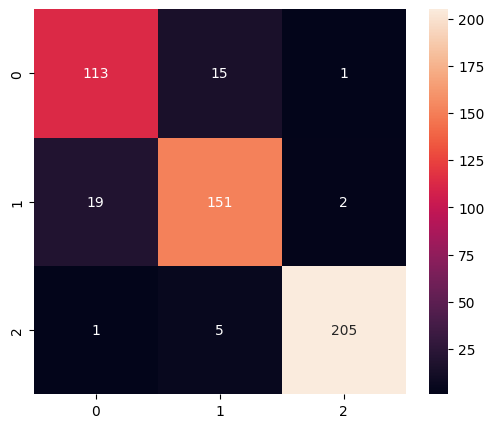

In [ ]:
code = {'glioma':0 ,'meningioma':1,'notumor':2}

X_test = []
y_test = []
for folder in  os.listdir(test) :
    files = glob.glob(pathname= str( test + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (160,160),3)
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

loaded_X_test = np.load('./X_test.npy')
loaded_y_test = np.load('./y_test.npy')
y_test = loaded_y_test

model = load_model('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelEffNetB5.h5')
pred=np.argmax(model.predict(loaded_X_test),axis=1)
cm = confusion_matrix(y_test,
                     pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm,fmt='.4g', annot=True)

16/16 [==============================] - 7s 394ms/step


<Axes: >

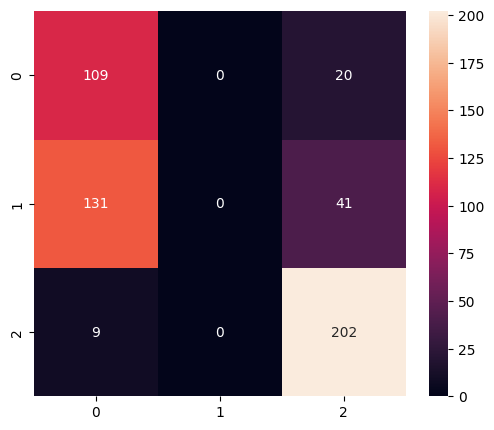

In [ ]:
code = {'glioma':0 ,'meningioma':1,'notumor':2 }

X_test = []
y_test = []
for folder in  os.listdir(test) :
    files = glob.glob(pathname= str( test + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (160,160),3)
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

loaded_X_test = np.load('./X_test.npy')
loaded_y_test = np.load('./y_test.npy')
y_test = loaded_y_test

model = load_model('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/resnet4_13.h5')
pred=np.argmax(model.predict(loaded_X_test),axis=1)
cm = confusion_matrix(y_test,
                     pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm,fmt='.4g', annot=True)

16/16 [==============================] - 3s 204ms/step


<Axes: >

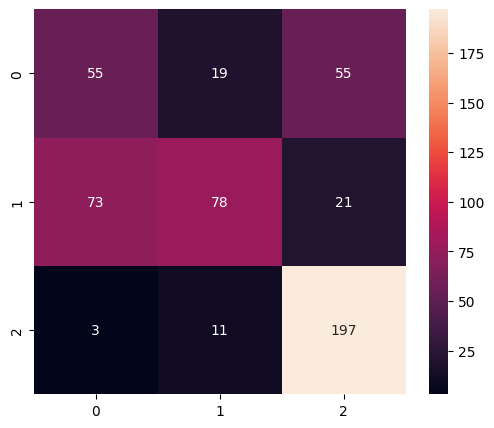

In [ ]:
code = {'glioma':0 ,'meningioma':1,'notumor':2 }

X_test = []
y_test = []
for folder in  os.listdir(test) :
    files = glob.glob(pathname= str( test + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (160,160),3)
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

loaded_X_test = np.load('./X_test.npy')
loaded_y_test = np.load('./y_test.npy')
y_test = loaded_y_test

model = load_model('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/ourModel.h5')
pred=np.argmax(model.predict(loaded_X_test),axis=1)
cm = confusion_matrix(y_test,
                     pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm,fmt='.4g', annot=True)

16/16 [==============================] - 173s 11s/step


<Axes: >

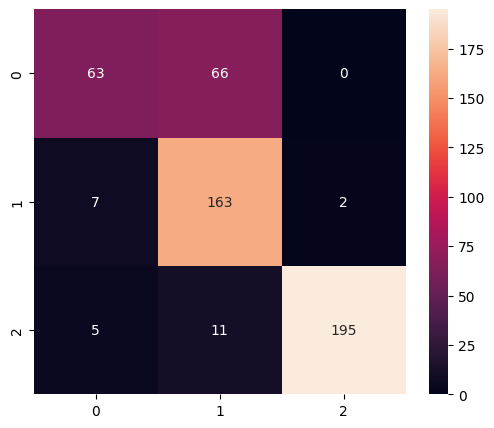

In [ ]:
code = {'glioma':0 ,'meningioma':1,'notumor':2 }

X_test = []
y_test = []
for folder in  os.listdir(test) :
    files = glob.glob(pathname= str( test + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (160,160),3)
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

loaded_X_test = np.load('./X_test.npy')
loaded_y_test = np.load('./y_test.npy')
y_test = loaded_y_test

model = load_model('/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/modelVGG16.h5')
pred=np.argmax(model.predict(loaded_X_test),axis=1)
cm = confusion_matrix(y_test,
                     pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm,fmt='.4g', annot=True)

K-Folds

In [ ]:
from sklearn.metrics import classification_report
from keras.models import load_model
target_names = ['notumor','meningioma','glioma'] # target values

# Print classification report after a train/test split:
print(classification_report(y, pred, target_names=target_names))

              precision    recall  f1-score   support

     notumor       0.84      0.49      0.62       129
  meningioma       0.68      0.95      0.79       172
      glioma       0.99      0.92      0.96       211

    accuracy                           0.82       512
   macro avg       0.84      0.79      0.79       512
weighted avg       0.85      0.82      0.82       512



In [ ]:
imageSize=160
train_dir = "/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/train"
test_dir =  "/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/test/"
from tqdm import tqdm

X = []
y = []
for folderName in os.listdir(test_dir):
    if not folderName.startswith('.'):


        if folderName in ['glioma']:
            label = 0
        elif folderName in ['meningioma']:
            label = 1
        elif folderName in ['notumor']:
            label = 2
        else:
            label = 3
        for image_filename in tqdm(os.listdir(test_dir + folderName)):
            img_file = cv2.imread(test_dir + folderName + '/' + image_filename)
            if img_file is not None:
                img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                img_arr = np.asarray(img_file)
                X.append(img_arr)
                y.append(label)
X = np.asarray(X)
y = np.asarray(y)

100%|██████████| 129/129 [00:04<00:00, 29.85it/s]


K-Fold 5 For Resnet4 Model

In [ ]:
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical


In [ ]:
def model_create():
  model2 = Sequential([

  Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
  MaxPool2D((2, 2)),

  Conv2D(32, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(rate=0.2),

  Conv2D(256, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(rate=0.2),

  Flatten(),
  Dense(units=1024, activation='relu'),
  Dropout(rate=0.3),

  Dense(units=3, activation='softmax') ])

  model2.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss='categorical_crossentropy', metrics= ['accuracy'])
  return model2


fold_no=5
strkf=StratifiedKFold(n_splits=fold_no, random_state = 11, shuffle = True)

X = np.asarray(X)
y = np.asarray(y)


fold = 1
cv_acc= []
cv_loss= []

for train_index,test_index in strkf.split(X,y):
  X_train,X_test=X[train_index],X[test_index]
  Y_train,Y_test=y[train_index],y[test_index]


  Y_train = to_categorical(Y_train, num_classes = 3)
  Y_test = to_categorical(Y_test, num_classes = 3)
  models=model_create()
  cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

  print(f' fold_no {fold}')

  history_cnn = models.fit(
            X_train, Y_train, epochs = 5, batch_size = 32, validation_data=(X_test,Y_test),
            callbacks = [cp])
  #scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

  models.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/basitCNN_kfold" +str(fold)+ ".h5")
  scores = models.evaluate(X_test, Y_test, verbose=0)
  cv_acc.append(scores[1] * 100)
  cv_loss.append(scores[0])
  fold = fold + 1
print('Sonuçlar')
for i in range(0, len(cv_acc)):
  print(f' Fold {i+1} - Loss: {cv_loss[i]} - Accuracy: %{cv_acc[i]}')
print('Ortalama sonuçlar:')
print(f' Accuracy: {np.mean(cv_acc)} (+- {np.std(cv_acc)})')
print(f' Loss: {np.mean(cv_loss)}')

 fold_no 1
Epoch 1/5
13/13 [==============================] - 17s 1s/step - loss: 4.1226 - accuracy: 0.5892 - val_loss: 1.3753 - val_accuracy: 0.4078
Epoch 2/5
13/13 [==============================] - 22s 2s/step - loss: 0.7710 - accuracy: 0.7726 - val_loss: 1.1178 - val_accuracy: 0.3398
Epoch 3/5
13/13 [==============================] - 17s 1s/step - loss: 0.5104 - accuracy: 0.8289 - val_loss: 1.2506 - val_accuracy: 0.4078
Epoch 4/5
13/13 [==============================] - 15s 1s/step - loss: 0.3674 - accuracy: 0.8778 - val_loss: 0.9858 - val_accuracy: 0.5631
Epoch 5/5
13/13 [==============================] - 14s 1s/step - loss: 0.2375 - accuracy: 0.8924 - val_loss: 0.9797 - val_accuracy: 0.4078


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



 fold_no 2
Epoch 1/5
13/13 [==============================] - 18s 1s/step - loss: 2.0550 - accuracy: 0.6235 - val_loss: 1.2851 - val_accuracy: 0.2524
Epoch 2/5
13/13 [==============================] - 15s 1s/step - loss: 0.6234 - accuracy: 0.7922 - val_loss: 1.1253 - val_accuracy: 0.2621
Epoch 3/5
13/13 [==============================] - 15s 1s/step - loss: 0.4079 - accuracy: 0.8851 - val_loss: 1.6175 - val_accuracy: 0.4078
Epoch 4/5
13/13 [==============================] - 15s 1s/step - loss: 0.3520 - accuracy: 0.8949 - val_loss: 0.9352 - val_accuracy: 0.4078
Epoch 5/5
13/13 [==============================] - 13s 1s/step - loss: 0.2563 - accuracy: 0.9071 - val_loss: 1.5221 - val_accuracy: 0.4078


 fold_no 3
Epoch 1/5
13/13 [==============================] - 19s 1s/step - loss: 4.1505 - accuracy: 0.5390 - val_loss: 1.6002 - val_accuracy: 0.2647
Epoch 2/5
13/13 [==============================] - 14s 1s/step - loss: 0.8483 - accuracy: 0.7561 - val_loss: 1.0214 - val_accuracy: 0.4608
Epoch 3/5
13/13 [==============================] - 13s 991ms/step - loss: 0.5563 - accuracy: 0.8171 - val_loss: 1.1254 - val_accuracy: 0.4216
Epoch 4/5
13/13 [==============================] - 14s 1s/step - loss: 0.4011 - accuracy: 0.8561 - val_loss: 0.9816 - val_accuracy: 0.4216
Epoch 5/5
13/13 [==============================] - 14s 1s/step - loss: 0.2560 - accuracy: 0.8902 - val_loss: 1.4504 - val_accuracy: 0.4216


 fold_no 4
Epoch 1/5
13/13 [==============================] - 17s 1s/step - loss: 4.0973 - accuracy: 0.6024 - val_loss: 2.7396 - val_accuracy: 0.3627
Epoch 2/5
13/13 [==============================] - 15s 1s/step - loss: 0.6390 - accuracy: 0.7780 - val_loss: 4.1408 - val_accuracy: 0.2549
Epoch 3/5
13/13 [==============================] - 15s 1s/step - loss: 0.5473 - accuracy: 0.8049 - val_loss: 3.0037 - val_accuracy: 0.2549
Epoch 4/5
13/13 [==============================] - 15s 1s/step - loss: 0.3336 - accuracy: 0.8683 - val_loss: 2.0913 - val_accuracy: 0.2549
Epoch 5/5
13/13 [==============================] - 15s 1s/step - loss: 0.2056 - accuracy: 0.9122 - val_loss: 1.5030 - val_accuracy: 0.5588


 fold_no 5
Epoch 1/5
13/13 [==============================] - 18s 1s/step - loss: 2.4624 - accuracy: 0.6537 - val_loss: 1.7611 - val_accuracy: 0.2549
Epoch 2/5
13/13 [==============================] - 20s 2s/step - loss: 0.8562 - accuracy: 0.7976 - val_loss: 2.3510 - val_accuracy: 0.2549
Epoch 3/5
13/13 [==============================] - 15s 1s/step - loss: 0.4827 - accuracy: 0.8585 - val_loss: 2.5502 - val_accuracy: 0.2549
Epoch 4/5
13/13 [==============================] - 13s 1s/step - loss: 0.4755 - accuracy: 0.8341 - val_loss: 1.9739 - val_accuracy: 0.4118
Epoch 5/5
13/13 [==============================] - 13s 970ms/step - loss: 0.2175 - accuracy: 0.9049 - val_loss: 1.9113 - val_accuracy: 0.4118
Sonuçlar
 Fold 1 - Loss: 0.9797297120094299 - Accuracy: %40.77669978141785
 Fold 2 - Loss: 1.5221296548843384 - Accuracy: %40.77669978141785
 Fold 3 - Loss: 1.4504401683807373 - Accuracy: %42.15686321258545
 Fold 4 - Loss: 1.5030183792114258 - Accuracy: %55.88235259056091
 Fold 5 - Loss: 1.

K-Fold 10 For Resnet4 Model

In [ ]:
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import StratifiedKFold
import numpy as np




In [ ]:
def model_create():
  model_k10 = Sequential([

  Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
  MaxPool2D((2, 2)),

  Conv2D(32, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(rate=0.2),

  Conv2D(256, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),
  Dropout(rate=0.2),

  Flatten(),
  Dense(units=1024, activation='relu'),
  Dropout(rate=0.3),

  Dense(units=3, activation='softmax') ])

  model_k10.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss='categorical_crossentropy', metrics= ['accuracy'])
  return model_k10


fold_no=10
strkf=StratifiedKFold(n_splits=fold_no, random_state = 11, shuffle = True)

X = np.asarray(X)
y = np.asarray(y)


fold = 1
cv_acc= []
cv_loss= []

for train_index,test_index in strkf.split(X,y):
  X_train,X_test=X[train_index],X[test_index]
  Y_train,Y_test=y[train_index],y[test_index]


  Y_train = to_categorical(Y_train, num_classes = 3)
  Y_test = to_categorical(Y_test, num_classes = 3)
  models=model_create()
  cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

  print(f' fold_no {fold}')
  history_k10 = models.fit(
            X_train, Y_train, epochs = 5, batch_size = 32, validation_data=(X_test,Y_test),
            callbacks = [cp])
  #scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

  models.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/model_10_kfold" +str(fold)+ ".h5")
  scores = models.evaluate(X_test, Y_test, verbose=0)
  cv_acc.append(scores[1] * 100)
  cv_loss.append(scores[0])
  fold = fold + 1
print('Sonuçlar')
for i in range(0, len(cv_acc)):
  print(f' Fold {i+1} - Loss: {cv_loss[i]} - Accuracy: %{cv_acc[i]}')
print('Ortalama sonuçlar:')
print(f' Accuracy: {np.mean(cv_acc)} (+- {np.std(cv_acc)})')
print(f' Loss: {np.mean(cv_loss)}')

 fold_no 1
Epoch 1/5
15/15 [==============================] - 25s 1s/step - loss: 2.9967 - accuracy: 0.6043 - val_loss: 2.2073 - val_accuracy: 0.2500
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 0.6659 - accuracy: 0.8000 - val_loss: 1.9618 - val_accuracy: 0.2500
Epoch 3/5
15/15 [==============================] - 22s 2s/step - loss: 0.4434 - accuracy: 0.8587 - val_loss: 1.0506 - val_accuracy: 0.3846
Epoch 4/5
15/15 [==============================] - 15s 934ms/step - loss: 0.3601 - accuracy: 0.8478 - val_loss: 2.3786 - val_accuracy: 0.2692
Epoch 5/5
15/15 [==============================] - 15s 955ms/step - loss: 0.3225 - accuracy: 0.9043 - val_loss: 1.3845 - val_accuracy: 0.2500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



 fold_no 2
Epoch 1/5
15/15 [==============================] - 19s 1s/step - loss: 3.1113 - accuracy: 0.6283 - val_loss: 1.2510 - val_accuracy: 0.3462
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 0.8943 - accuracy: 0.7587 - val_loss: 1.3980 - val_accuracy: 0.3846
Epoch 3/5
15/15 [==============================] - 15s 1s/step - loss: 0.4525 - accuracy: 0.8609 - val_loss: 2.4484 - val_accuracy: 0.4038
Epoch 4/5
15/15 [==============================] - 16s 1s/step - loss: 0.3530 - accuracy: 0.8826 - val_loss: 3.7099 - val_accuracy: 0.4038
Epoch 5/5
15/15 [==============================] - 15s 1s/step - loss: 0.2301 - accuracy: 0.9043 - val_loss: 3.7595 - val_accuracy: 0.4038


 fold_no 3
Epoch 1/5
15/15 [==============================] - 18s 1s/step - loss: 3.3277 - accuracy: 0.5900 - val_loss: 1.1155 - val_accuracy: 0.5098
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 0.9321 - accuracy: 0.7440 - val_loss: 1.6139 - val_accuracy: 0.4118
Epoch 3/5
15/15 [==============================] - 15s 1s/step - loss: 0.4048 - accuracy: 0.8395 - val_loss: 1.9612 - val_accuracy: 0.4314
Epoch 4/5
15/15 [==============================] - 18s 1s/step - loss: 0.3142 - accuracy: 0.8785 - val_loss: 2.5856 - val_accuracy: 0.4314
Epoch 5/5
15/15 [==============================] - 15s 1s/step - loss: 0.2244 - accuracy: 0.8894 - val_loss: 2.6060 - val_accuracy: 0.4314


 fold_no 4
Epoch 1/5
15/15 [==============================] - 19s 1s/step - loss: 2.4788 - accuracy: 0.6486 - val_loss: 1.2869 - val_accuracy: 0.4510
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 1.0368 - accuracy: 0.7766 - val_loss: 1.4380 - val_accuracy: 0.2745
Epoch 3/5
15/15 [==============================] - 15s 997ms/step - loss: 0.4739 - accuracy: 0.8351 - val_loss: 1.2388 - val_accuracy: 0.2549
Epoch 4/5
15/15 [==============================] - 14s 972ms/step - loss: 0.2402 - accuracy: 0.9046 - val_loss: 1.7235 - val_accuracy: 0.2549
Epoch 5/5
15/15 [==============================] - 14s 937ms/step - loss: 0.2242 - accuracy: 0.9002 - val_loss: 0.9264 - val_accuracy: 0.5882


 fold_no 5
Epoch 1/5
15/15 [==============================] - 17s 940ms/step - loss: 3.9085 - accuracy: 0.6009 - val_loss: 1.3637 - val_accuracy: 0.3333
Epoch 2/5
15/15 [==============================] - 14s 895ms/step - loss: 0.6253 - accuracy: 0.7896 - val_loss: 2.0409 - val_accuracy: 0.2549
Epoch 3/5
15/15 [==============================] - 14s 918ms/step - loss: 0.5088 - accuracy: 0.8178 - val_loss: 1.8703 - val_accuracy: 0.2549
Epoch 4/5
15/15 [==============================] - 15s 981ms/step - loss: 0.5200 - accuracy: 0.7874 - val_loss: 1.0982 - val_accuracy: 0.4118
Epoch 5/5
15/15 [==============================] - 15s 983ms/step - loss: 0.3213 - accuracy: 0.8633 - val_loss: 1.2712 - val_accuracy: 0.3333


 fold_no 6
Epoch 1/5
15/15 [==============================] - 17s 993ms/step - loss: 2.4908 - accuracy: 0.6746 - val_loss: 1.1923 - val_accuracy: 0.4118
Epoch 2/5
15/15 [==============================] - 15s 958ms/step - loss: 0.6726 - accuracy: 0.7983 - val_loss: 1.8593 - val_accuracy: 0.3333
Epoch 3/5
15/15 [==============================] - 15s 1s/step - loss: 0.3979 - accuracy: 0.8590 - val_loss: 1.5868 - val_accuracy: 0.2549
Epoch 4/5
15/15 [==============================] - 15s 1s/step - loss: 0.2602 - accuracy: 0.8937 - val_loss: 2.9120 - val_accuracy: 0.2549
Epoch 5/5
15/15 [==============================] - 15s 1s/step - loss: 0.2800 - accuracy: 0.8980 - val_loss: 1.9252 - val_accuracy: 0.2549


 fold_no 7
Epoch 1/5
15/15 [==============================] - 18s 966ms/step - loss: 3.1384 - accuracy: 0.5879 - val_loss: 1.2871 - val_accuracy: 0.2157
Epoch 2/5
15/15 [==============================] - 15s 953ms/step - loss: 0.7592 - accuracy: 0.7918 - val_loss: 2.3006 - val_accuracy: 0.4118
Epoch 3/5
15/15 [==============================] - 14s 929ms/step - loss: 0.4118 - accuracy: 0.8525 - val_loss: 2.7746 - val_accuracy: 0.4118
Epoch 4/5
15/15 [==============================] - 15s 974ms/step - loss: 0.1960 - accuracy: 0.9219 - val_loss: 4.2884 - val_accuracy: 0.4118
Epoch 5/5
15/15 [==============================] - 14s 928ms/step - loss: 0.1781 - accuracy: 0.9262 - val_loss: 3.1759 - val_accuracy: 0.4118


 fold_no 8
Epoch 1/5
15/15 [==============================] - 24s 1s/step - loss: 2.9826 - accuracy: 0.6074 - val_loss: 1.7031 - val_accuracy: 0.2549
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 0.7400 - accuracy: 0.7744 - val_loss: 1.1173 - val_accuracy: 0.4118
Epoch 3/5
15/15 [==============================] - 19s 1s/step - loss: 0.5322 - accuracy: 0.7983 - val_loss: 1.0506 - val_accuracy: 0.4118
Epoch 4/5
15/15 [==============================] - 15s 1s/step - loss: 0.2741 - accuracy: 0.8894 - val_loss: 1.2325 - val_accuracy: 0.4118
Epoch 5/5
15/15 [==============================] - 15s 1s/step - loss: 0.2797 - accuracy: 0.8915 - val_loss: 1.4716 - val_accuracy: 0.4118


 fold_no 9
Epoch 1/5
15/15 [==============================] - 18s 1s/step - loss: 2.4714 - accuracy: 0.5944 - val_loss: 0.7821 - val_accuracy: 0.5686
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 1.7367 - accuracy: 0.6898 - val_loss: 1.3159 - val_accuracy: 0.3529
Epoch 3/5
15/15 [==============================] - 15s 1s/step - loss: 0.6722 - accuracy: 0.8265 - val_loss: 1.3112 - val_accuracy: 0.3333
Epoch 4/5
15/15 [==============================] - 15s 997ms/step - loss: 0.3811 - accuracy: 0.8677 - val_loss: 1.0338 - val_accuracy: 0.4118
Epoch 5/5
15/15 [==============================] - 15s 1s/step - loss: 0.2202 - accuracy: 0.9111 - val_loss: 2.2231 - val_accuracy: 0.4118


 fold_no 10
Epoch 1/5
15/15 [==============================] - 18s 1s/step - loss: 2.4684 - accuracy: 0.6399 - val_loss: 0.9494 - val_accuracy: 0.4314
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 0.6052 - accuracy: 0.8178 - val_loss: 1.2432 - val_accuracy: 0.3725
Epoch 3/5
15/15 [==============================] - 15s 989ms/step - loss: 0.3634 - accuracy: 0.8742 - val_loss: 1.0439 - val_accuracy: 0.4902
Epoch 4/5
15/15 [==============================] - 15s 1s/step - loss: 0.3763 - accuracy: 0.8807 - val_loss: 1.1851 - val_accuracy: 0.3922
Epoch 5/5
15/15 [==============================] - 15s 987ms/step - loss: 0.3475 - accuracy: 0.8937 - val_loss: 1.4986 - val_accuracy: 0.4118
Sonuçlar
 Fold 1 - Loss: 1.3845245838165283 - Accuracy: %25.0
 Fold 2 - Loss: 3.7594616413116455 - Accuracy: %40.38461446762085
 Fold 3 - Loss: 2.605952024459839 - Accuracy: %43.13725531101227
 Fold 4 - Loss: 0.926388144493103 - Accuracy: %58.82353186607361
 Fold 5 - Loss: 1.27121186256

K-Fold 5 For EffnetB5 Model

In [ ]:
from keras.applications.efficientnet import EfficientNetB5

from keras import layers
from keras.models import Sequential

def model_create():
  model_EffNetB5_1101 = Sequential()
  model_EffNetB5_1101.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(160,160,3)))
  model_EffNetB5_1101.add(layers.GlobalAveragePooling2D())
  model_EffNetB5_1101.add(layers.Dropout(0.5))
  model_EffNetB5_1101.add(layers.Dense(3,activation = 'softmax'))

  model_EffNetB5_1101.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])
  return model_EffNetB5_1101

fold_no=5
strkf=StratifiedKFold(n_splits=fold_no, random_state = 11, shuffle = True)

X = np.asarray(X)
y = np.asarray(y)


fold = 1
cv_acc= []
cv_loss= []

for train_index,test_index in strkf.split(X,y):
  X_train,X_test=X[train_index],X[test_index]
  Y_train,Y_test=y[train_index],y[test_index]


  Y_train = to_categorical(Y_train, num_classes = 3)
  Y_test = to_categorical(Y_test, num_classes = 3)
  models=model_create()
  cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

  print(f' fold_no {fold}')
  history_eff = models.fit(
            X_train, Y_train, epochs = 3, batch_size = 32, validation_data=(X_test,Y_test),
            callbacks = [cp])

  models.save("/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/K-folds/k5_effNetB5Model" +str(fold)+ ".h5")
  scores = models.evaluate(X_test, Y_test, verbose=0)
  cv_acc.append(scores[1] * 100)
  cv_loss.append(scores[0])
  fold = fold + 1
print('Sonuçlar')
for i in range(0, len(cv_acc)):
  print(f' Fold {i+1} - Loss: {cv_loss[i]} - Accuracy: %{cv_acc[i]}')
print('Ortalama sonuçlar:')
print(f' Accuracy: {np.mean(cv_acc)} (+- {np.std(cv_acc)})')
print(f' Loss: {np.mean(cv_loss)}')

115263384/115263384 [==============================] - 1s 0us/step
 fold_no 1
Epoch 1/3
13/13 [==============================] - 349s 21s/step - loss: 0.5307 - accuracy: 0.7726 - val_loss: 1.1897 - val_accuracy: 0.3592
Epoch 2/3
13/13 [==============================] - 247s 19s/step - loss: 0.1760 - accuracy: 0.9438 - val_loss: 1.5978 - val_accuracy: 0.4078
Epoch 3/3
13/13 [==============================] - 250s 19s/step - loss: 0.1931 - accuracy: 0.9462 - val_loss: 2.2970 - val_accuracy: 0.4078


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



 fold_no 2
Epoch 1/3
13/13 [==============================] - 323s 20s/step - loss: 0.6281 - accuracy: 0.7164 - val_loss: 1.1925 - val_accuracy: 0.4078
Epoch 2/3
13/13 [==============================] - 252s 19s/step - loss: 0.2714 - accuracy: 0.9169 - val_loss: 1.4945 - val_accuracy: 0.4078
Epoch 3/3
13/13 [==============================] - 250s 19s/step - loss: 0.1994 - accuracy: 0.9095 - val_loss: 1.1556 - val_accuracy: 0.4078
 fold_no 3
Epoch 1/3
13/13 [==============================] - 329s 20s/step - loss: 0.6200 - accuracy: 0.7244 - val_loss: 1.0837 - val_accuracy: 0.4216
Epoch 2/3
13/13 [==============================] - 264s 20s/step - loss: 0.2894 - accuracy: 0.8878 - val_loss: 1.4853 - val_accuracy: 0.4216
Epoch 3/3
13/13 [==============================] - 259s 20s/step - loss: 0.2169 - accuracy: 0.9122 - val_loss: 1.3284 - val_accuracy: 0.4216
 fold_no 4
Epoch 1/3
13/13 [==============================] - 335s 21s/step - loss: 0.5998 - accuracy: 0.7463 - val_loss: 1.1347 - v

In [ ]:
from keras.applications.efficientnet import EfficientNetB5

from keras import layers
from keras.models import Sequential

def model_create():
  model_EffNetB5_1101 = Sequential()
  model_EffNetB5_1101.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(160,160,3)))
  model_EffNetB5_1101.add(layers.GlobalAveragePooling2D())
  model_EffNetB5_1101.add(layers.Dropout(0.5))
  model_EffNetB5_1101.add(layers.Dense(4,activation = 'softmax'))

  model_EffNetB5_1101.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])
  return model_EffNetB5_1101

fold_no=5
strkf=StratifiedKFold(n_splits=fold_no, random_state = 11, shuffle = True)

X = np.asarray(X)
y = np.asarray(y)


fold = 1
cv_acc= []
cv_loss= []

for train_index,test_index in strkf.split(X,y):
  X_train,X_test=X[train_index],X[test_index]
  Y_train,Y_test=y[train_index],y[test_index]


  Y_train = to_categorical(Y_train, num_classes = 4)
  Y_test = to_categorical(Y_test, num_classes = 4)
  models=model_create()
  cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)
  print(f' fold_no {fold}')

  history_eff = models.fit(
            X_train, Y_train, epochs = 5, batch_size = 32, validation_data=(X_test,Y_test),
            callbacks = [cp])

  models.save("/content/drive/MyDrive/K-folds/k5_effNetB5Model" +str(fold)+ ".h5")
  scores = models.evaluate(X_test, Y_test, verbose=0)
  cv_acc.append(scores[1] * 100)
  cv_loss.append(scores[0])
  fold = fold + 1
print('Sonuçlar')
for i in range(0, len(cv_acc)):
  print(f' Fold {i+1} - Loss: {cv_loss[i]} - Accuracy: %{cv_acc[i]}')
print('Ortalama sonuçlar:')
print(f' Accuracy: {np.mean(cv_acc)} (+- {np.std(cv_acc)})')
print(f' Loss: {np.mean(cv_loss)}')

Data Augmentation

In [ ]:
def isCheck_Klasor(path):
    if not os.path.isdir(path):
        os.mkdir(path)

datagen = ImageDataGenerator(
rotation_range=180,
width_shift_range=0.3,
height_shift_range=0.3,
shear_range=0.15,
zoom_range=0.5,
horizontal_flip=True)

classes=os.listdir(train)

path1='/content/drive/MyDrive/Brain_Tumor_MRI_Dataset/Data_Augmentation/'
isCheck_Klasor(path1)

for class_name in classes:
    save_here = path1+class_name
    isCheck_Klasor(save_here)

    path2=train+class_name+'/'
    files=os.listdir(path2)

    for file in files:
        image_path = path2+file
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image = cv2.addWeighted (image, 4, cv2.GaussianBlur(image, (0,0), 512/10), -4, 128)
        image = np.expand_dims(image, 0)
        datagen.fit(image)

        if class_name=="glioma":
            range_value=3
        elif class_name=="meningioma":
            range_value=9
        elif class_name=="notumor":
            range_value=12


        for x, val in zip(datagen.flow(image,save_to_dir=save_here,save_prefix='aug',save_format='jpg'),range(range_value)):
            pass

        print (class_name,file, " islem bitti...")

notumor Tr-no_0585.jpg  islem bitti...
notumor Tr-no_0584.jpg  islem bitti...
notumor Tr-no_0582.jpg  islem bitti...
notumor Tr-no_0586.jpg  islem bitti...
notumor Tr-no_0581.jpg  islem bitti...
notumor Tr-no_0583.jpg  islem bitti...
notumor Tr-no_0617.jpg  islem bitti...
notumor Tr-no_0610.jpg  islem bitti...
notumor Tr-no_0611.jpg  islem bitti...
notumor Tr-no_0619.jpg  islem bitti...
notumor Tr-no_0597.jpg  islem bitti...
notumor Tr-no_0622.jpg  islem bitti...
notumor Tr-no_0593.jpg  islem bitti...
notumor Tr-no_0601.jpg  islem bitti...
notumor Tr-no_0588.jpg  islem bitti...
notumor Tr-no_0596.jpg  islem bitti...
notumor Tr-no_0592.jpg  islem bitti...
notumor Tr-no_0604.jpg  islem bitti...
notumor Tr-no_0589.jpg  islem bitti...
notumor Tr-no_0616.jpg  islem bitti...
notumor Tr-no_0620.jpg  islem bitti...
notumor Tr-no_0599.jpg  islem bitti...
notumor Tr-no_0608.jpg  islem bitti...
notumor Tr-no_0624.jpg  islem bitti...
notumor Tr-no_0612.jpg  islem bitti...
notumor Tr-no_0618.jpg  i

KeyboardInterrupt: ignored

Classifiers

In [ ]:
X_train = []
y_train = []
code = {'glioma':0 ,'meningioma':1,'notumor':2 }
for folder in  os.listdir(train) :
    files = glob.glob(pathname= str( train + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (160,160))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

X_test = []
y_test = []
for folder in  os.listdir(test) :
    files = glob.glob(pathname= str( test + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image , (160,160))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

In [ ]:
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

X_train = loaded_X_train.reshape([-1, np.product((160,160,3))])
X_test = loaded_X_test.reshape([-1, np.product((160,160,3))])
y_train = loaded_y_train
y_test = loaded_y_test
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
log_reg  = LogisticRegression(solver='lbfgs', max_iter=100)
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier(max_depth=2, random_state=0)
svm = SVC()

In [ ]:
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
# dtc.fit(X_train, y_train)
# rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SVC()

In [ ]:
knn_predcited = knn.predict(X_test)
log_reg_predcited = log_reg.predict(X_test)
# dtc_predcited = dtc.predict(X_test)
# rfc_predcited = rfc.predict(X_test)
# svm_predcited = svm.predict(X_test)

In [ ]:
def plot_cm(predictions, y_test, title):
  labels = ['glioma', 'meningioma', 'notumor']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

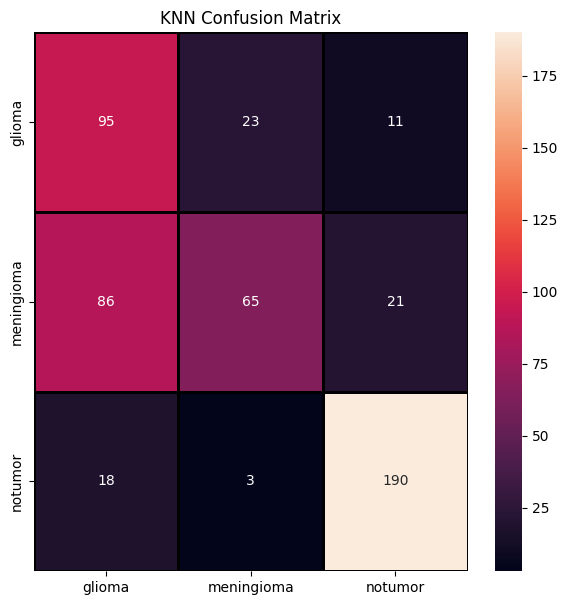

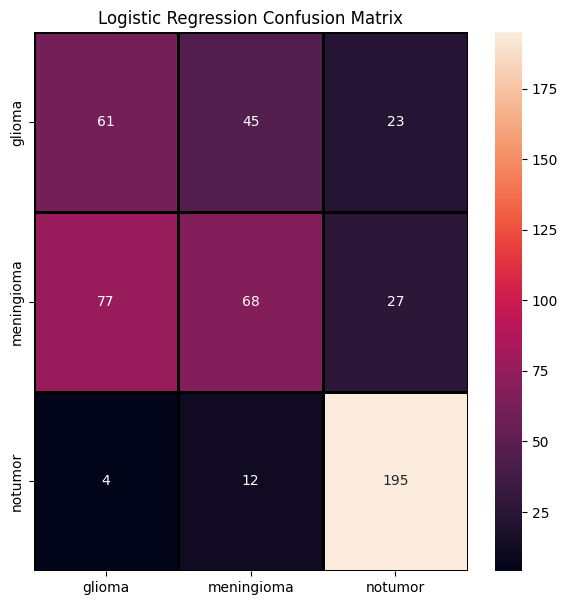

In [ ]:
plot_cm(knn_predcited, y_test, 'KNN Confusion Matrix')

plot_cm(log_reg_predcited, y_test, 'Logistic Regression Confusion Matrix')
# plot_cm(dtc_predcited, y_test, 'Decision Tree Confusion Matrix')

# plot_cm(rfc_predcited, y_test, 'Random Forests Confusion Matrix')

# plot_cm(svm_predcited, y_test, 'Support Vector Machine Confusion Matrix')